# Creating feature that will be learned
This section will concentrate on the 2021-2022 season.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install nba_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
games = pd.read_csv(f"GamesRegularSeason_10years.csv")
players = pd.read_csv("players_data_2021.csv")
spec_players = pd.read_csv("players_specs_10years.csv")
spec_players = spec_players.loc[spec_players["SEASON_ID"] == "2021-22"]

nb_teams = 30
assert nb_teams == len(games['HOME_TEAM_ID'].unique())
nb_players = len(players['PLAYER_ID'].unique())

## First idea

Create a data set with one hot vectors to encode teams that are playing as well as players that are playing.

Issues : lot of zeros in the feature vectors

In [ ]:
# Create a new DataFrame to store the one-hot vectors for each game
one_hot_df_train = pd.DataFrame()

games_train = games.copy()
games_train = games_train.loc[games_train['GAME_DATE'] <= '2022-04-10'].reset_index(drop=True)
games_train = games_train.loc[games_train['GAME_DATE'] >= '2021-10-19'].reset_index(drop=True)
# training set is composed of all the regular season games

# Create one-hot vectors for each team and player in each game
for index, game in games_train.iterrows():
    # Create one-hot vectors for the teams
    home_team_vector = pd.Series(np.zeros(nb_teams), index=games['HOME_TEAM_ID'].unique())
    away_team_vector = pd.Series(np.zeros(nb_teams), index=games['AWAY_TEAM_ID'].unique())
    home_team_vector[game['HOME_TEAM_ID']] = 1
    away_team_vector[game['AWAY_TEAM_ID']] = 1

    # Create one-hot vectors for the players
    home_players = players[(players['TEAM_ABBREVIATION'] == game['HOME_TEAM_ID']) & (players['GAME_ID'] == game['GAME_ID'])]['PLAYER_ID'].tolist()
    away_players = players[(players['TEAM_ABBREVIATION'] == game['AWAY_TEAM_ID']) & (players['GAME_ID'] == game['GAME_ID'])]['PLAYER_ID'].tolist()
    player_vector = pd.Series(np.zeros(nb_players), index=players['PLAYER_ID'].unique())
    player_vector[home_players] = 1
    player_vector[away_players] = 1

    # Merge the one-hot vectors for each team and player into a single row
    game_vector = pd.concat([home_team_vector, away_team_vector, player_vector])

    # Add the game vector to the one-hot DataFrame
    one_hot_df_train = one_hot_df_train.append(game_vector, ignore_index=True)

# Rename the columns in the one-hot DataFrame
one_hot_df_train.columns = np.concatenate([games['HOME_TEAM_ID'].unique(), games['AWAY_TEAM_ID'].unique(), players['PLAYER_ID'].unique()])

# Add the game outcome to the one-hot DataFrame
one_hot_df_train['Outcome'] = games_train['HOME_TEAM_WIN'].astype(int)

## Second idea
Encode stats of playing players in the feature vectors.</br>
Since we have 10 players, we can have a feature vector of length
$nbTeams \times nbPlayers \times nbSelectedStats$

We start by training the model with the players average statistics of a specific season on each game of the regular season. The test set would be the playoffs.

Next up would be to average the $n$ last games in order to have something more accurate. Best thing would have to compute the actual averages of each player at the date of the computed game, but would be really costly.

In [ ]:
class Preprocess:
    def __init__(self,nb_players) -> None:
        self.number_of_players = nb_players
        self.games = pd.read_csv(f"GamesRegularSeason_10years.csv")
        self.playoffs = pd.read_csv(f"GamesPlayoffs_10years.csv")
        self.spec_players = pd.read_csv("players_specs_10years.csv")
        print(f"Number of teams : {len(self.games['HOME_TEAM_ID'].unique())}") # we can have more than 30 teams

    def prepare_dataset(self, year):
        """Retrieve the correct data from the files.
        Convert height from feet and inches to cm.
        Convert time played from minutes:secondes to minutes as floats.
        Keep only the players that played the most during a game."""

        year_id = str(year) + "-" + str(year+1)[-2:]
        spec_players = self.spec_players.loc[self.spec_players["SEASON_ID"] == year_id]
      #   cols_for_spec_players = ['PLAYER_ID', 'PLAYER_AGE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
      #  'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'HEIGHT','WEIGHT', 'SEASON_EXP']
        cols_for_spec_players = ['PLAYER_ID', 'MIN', 'FGA', 'FG_PCT', 'FG3A', 'FG3_PCT', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'HEIGHT', 'WEIGHT']
        spec_players = spec_players[cols_for_spec_players]

        # convert FEET and INCHES to cm
        spec_players['FEET'], spec_players['INCHES'] = spec_players['HEIGHT'].str.split('-', 1).str
        spec_players['FEET'] = pd.to_numeric(spec_players['FEET'])
        spec_players['INCHES'] = pd.to_numeric(spec_players['INCHES'])
        spec_players['HEIGHT_CM'] = spec_players['FEET'] * 30.48 + spec_players['INCHES'] * 2.54
        # drop the original FEET and INCHES columns
        spec_players = spec_players.drop(['HEIGHT', 'FEET', 'INCHES'], axis=1)

        players = pd.read_csv(f"players_data_{year}.csv")
        col_players = ["PLAYER_ID","GAME_ID","TEAM_ID","MIN","TEAM_ABBREVIATION"]

        # convert MIN as "minutes:secondes" to minutes as floats
        players['MINUTES'], players['SECONDS'] = players['MIN'].str.split(':', 1).str
        players['MINUTES'] = pd.to_numeric(players['MINUTES'])
        players['SECONDS'] = pd.to_numeric(players['SECONDS'])
        players['MIN'] = players['MINUTES'] + players['SECONDS'] / 60
        # drop the original MINUTES and SECONDS columns
        players = players.drop(['MINUTES', 'SECONDS'], axis=1)

        # only keep the best players of each team that played the most
        top_players = players[col_players].groupby(['GAME_ID', 'TEAM_ID']).apply(lambda x: x.sort_values('MIN', ascending=False).head(self.number_of_players))
        top_players = top_players.reset_index(drop=True)
        top_players.drop("MIN",axis=1,inplace=True) # not needed anymore

        # merge spec players and players that played
        stats = pd.merge(spec_players,top_players,on="PLAYER_ID")
        stats.sort_values(["GAME_ID","PLAYER_ID"])

        return stats

    def build_dataframe_for_year(self,year,playoffs):
        """Build in a dataframe a dataset where each column represents a game.
        For each game, we store the statistics of each player that played."""

        stats = self.prepare_dataset(year)

        # retrieve data we need from games dataframe
        group_by = ["GAME_DATE","GAME_ID","HOME_TEAM_ID","AWAY_TEAM_ID","HOME_TEAM_WIN"]
        if playoffs:
          game_specs = self.playoffs[group_by]
        else:
          game_specs = self.games[group_by]
        # merge on GAME_ID, to form a dataset with stats from each player that played during GAME_ID
        game_stats_merge = pd.merge(stats,game_specs,on="GAME_ID")

        # create a new dataframe with the players grouped by the home team
        home_players = game_stats_merge[game_stats_merge['TEAM_ABBREVIATION'] == game_stats_merge['HOME_TEAM_ID']] \
            .groupby(group_by) \
            .agg(list) \
            .reset_index()

        # create a new dataframe with the players grouped by the away team
        away_players = game_stats_merge[game_stats_merge['TEAM_ABBREVIATION'] != game_stats_merge['HOME_TEAM_ID']] \
            .groupby(group_by) \
            .agg(list) \
            .reset_index()

        # merge the two dataframes
        dataset = pd.merge(home_players, away_players, on=group_by, suffixes=("_HOME","_AWAY"))
        # drop columns not needed
        cols_to_drop = ["TEAM_ID","TEAM_ABBREVIATION"]
        cols_final_to_drop = [col + "_HOME" for col in cols_to_drop] + [col + "_AWAY" for col in cols_to_drop]
        dataset.drop(cols_final_to_drop,axis=1,inplace=True)


        # columns now contain lists of stats for each player, we separate into new columns here
        excluded_columns = ['GAME_DATE', 'GAME_ID', 'HOME_TEAM_ID', 'AWAY_TEAM_ID', 'HOME_TEAM_WIN','PLAYER_ID_HOME','PLAYER_ID_AWAY']
        # don't separate for these columns, they either have non list values, or are columns we don't need anymore
        columns = list(dataset.columns)
        for col in columns:
            if col in excluded_columns:
                continue
            dataset = dataset.join(dataset[col].apply(pd.Series).add_prefix(col + "_"))

        # remove all previous columns, since we won't feed them to the model
        columns.remove('HOME_TEAM_WIN') # we keep HOME_TEAM_WIN, giving the labels for the model
        dataset.drop(columns,axis=1,inplace=True)

        # fill all NaN with zeros
        dataset.fillna(0,inplace=True)

        return dataset

    def dataset_for_n_years(self, n_years : int, include_playoffs = False):
        dfs = []
        for year in range(2023 - n_years,2023):
            dataset = self.build_dataframe_for_year(year,include_playoffs)
            dfs.append(dataset)
        concat = pd.concat(dfs)
        concat.fillna(0,inplace=True)
        return concat

In [ ]:
nb_players = 3
nb_years = 10

In [ ]:
preprocess = Preprocess(nb_players)
dataset = preprocess.dataset_for_n_years(nb_years) # no playoffs

Number of teams : 30


<ipython-input-3-2f8340ad870c>:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  spec_players['FEET'], spec_players['INCHES'] = spec_players['HEIGHT'].str.split('-', 1).str
<ipython-input-3-2f8340ad870c>:24: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  spec_players['FEET'], spec_players['INCHES'] = spec_players['HEIGHT'].str.split('-', 1).str
<ipython-input-3-2f8340ad870c>:35: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  players['MINUTES'], players['SECONDS'] = players['MIN'].str.split(':', 1).str
<ipython-input-3-2f8340ad870c>:35: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  players['MINUTES'], players['SECONDS'] = players['MIN'].str.split(':', 1).str
<ipython-input-3-2f8340ad870c>:24: FutureWarning: In a future vers

In [ ]:
dataset.to_csv(f"dataset_preprocess_{nb_years}years_{nb_players}players.csv")

In [ ]:
# list(dataset.columns)
dataset = pd.read_csv(f"dataset_preprocess_{nb_years}years_{nb_players}players.csv")

## Third idea

Study on the attributes.
- check correlation between attributes
- check relation between winning attribute and each attribute
- check "synchronisme" between attributes $\frac{X^T.X}n$
- check "synchronisme" between samples $\frac{X.X^T}n$
- score de Fisher for filter
- PCA, even thought it's very sparse, as players have different roles, can be use on team stats though
- t-SNE, to model data with ower dimension

#### Correlation

In [ ]:
preproc = Preprocess(5)
stats = preproc.prepare_dataset(2021)

# retrieve data we need from games dataframe
group_by = ["GAME_DATE","GAME_ID","HOME_TEAM_ID","AWAY_TEAM_ID","HOME_TEAM_WIN"]
game_specs = preproc.games[group_by]
# merge on GAME_ID, to form a dataset with stats from each player that played during GAME_ID
game_stats_merge = pd.merge(stats,game_specs,on="GAME_ID")

corr = game_stats_merge.corr()

Number of teams : 30


<ipython-input-3-2f8340ad870c>:24: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  spec_players['FEET'], spec_players['INCHES'] = spec_players['HEIGHT'].str.split('-', 1).str
<ipython-input-3-2f8340ad870c>:24: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  spec_players['FEET'], spec_players['INCHES'] = spec_players['HEIGHT'].str.split('-', 1).str
<ipython-input-3-2f8340ad870c>:35: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  players['MINUTES'], players['SECONDS'] = players['MIN'].str.split(':', 1).str
<ipython-input-3-2f8340ad870c>:35: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  players['MINUTES'], players['SECONDS'] = players['MIN'].str.split(':', 1).str
<ipython-input-39-05490c695ce8>:10: FutureWarning: The default val

<Axes: >

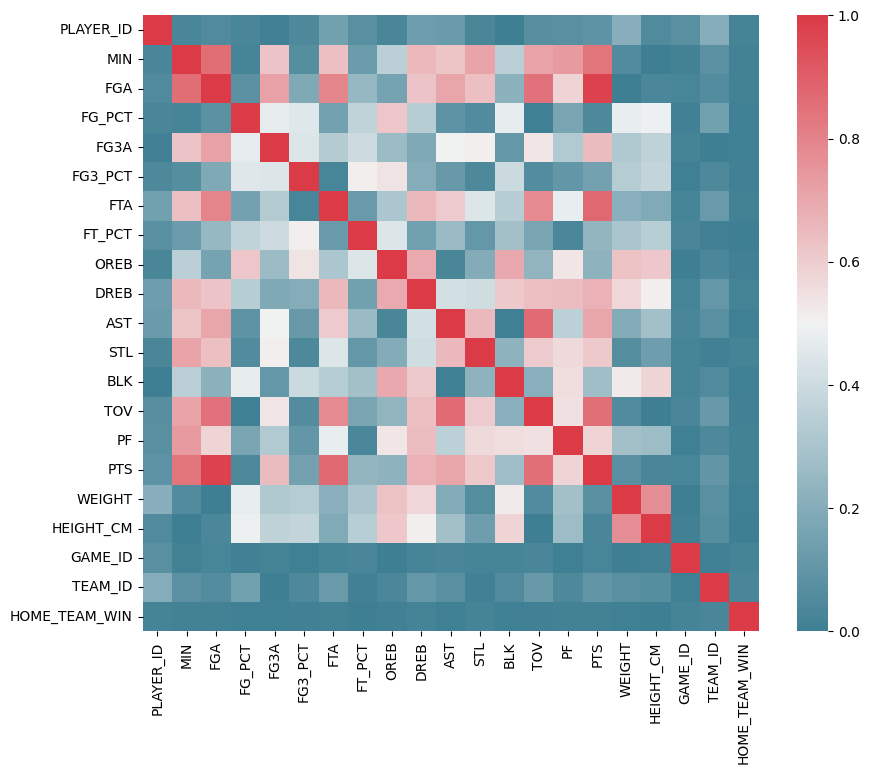

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(abs(corr),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=0, vmax=1.0,
    square=True, ax=ax)

#### Synchronisme entre attributs

In [ ]:
stats = game_stats_merge.to_numpy()
sync_attr = (stats.T @ stats)/len(list(game_stats_merge.columns))

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(sync_attr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=0, vmax=1.0,
    square=True, ax=ax)

#### Synchronisme entre examples

In [ ]:
stats = game_stats_merge.to_numpy()
sync_sample = (stats @ stats.T)/len(game_stats_merge)

#### Score de Fisher

## Fourth idea

For example, height for one specific player will not be really correlated to the team winning or not. As basketball is a team sport, we can not evaluate per player, it has to be as a whole.
Get more attributes, focusing on team attributes. Maybe create a new model evaluating team performance, then combine with previous model focusing on player's performance.

- traditional statistics but for teams <a href="https://www.nba.com/stats/teams/traditional">link</a>
- defensive and offensive rating <a href="https://www.nba.com/stats/teams/advanced">link</a>
- TS%, eFG%, pace, PIE (combines a lot of stats), PER (more complex, but defensive importance is low  dont know if available with NBA api)
- average height and weight for each team for one game

Check Correlation matrix on team attributes, should be more useful than correlation between winning and individual attributes

In [3]:
from nba_api.stats.endpoints import leaguedashteamstats

games = pd.read_csv("GamesRegularSeason_10years.csv")
# games.cols
games_cols = ['GAME_ID', 'GAME_DATE', 'HOME_TEAM_WIN', 'HOME_TEAM_ID',
       'HOME_TEAM_NAME', 'HOME_FGA', 'HOME_FG_PCT',
       'HOME_FTA', 'HOME_FT_PCT', 'HOME_FG3A', 'HOME_FG3_PCT',
       'HOME_OREB', 'HOME_DREB', 'HOME_AST', 'HOME_STL',
       'HOME_BLK', 'HOME_TOV', 'HOME_PF', 'AWAY_TEAM_ID',
       'AWAY_TEAM_NAME', 'AWAY_FGA', 'AWAY_FG_PCT',
       'AWAY_FTA', 'AWAY_FT_PCT', 'AWAY_FG3A', 'AWAY_FG3_PCT',
       'AWAY_OREB', 'AWAY_DREB', 'AWAY_AST', 'AWAY_STL',
       'AWAY_BLK', 'AWAY_TOV', 'AWAY_PF']
games_filtered_cols = games[games_cols]

In [ ]:
n_years = 9
dfs = []
for season in range(2022 - n_years,2022):
  games_filtered = games_filtered_cols[games_filtered_cols["GAME_DATE"] > str(season) + "-10-01"]
  games_filtered = games_filtered[games_filtered["GAME_DATE"] < str(season + 1) + "-06-01"]

  response = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense="Advanced", season= str(season) + "-" + str(season+1)[-2:])
  team_stats = response.get_data_frames()[0]
  # team_stats.cols
  team_stats_cols = ["TEAM_NAME","OFF_RATING","DEF_RATING","AST_PCT","AST_TO","OREB_PCT","DREB_PCT","TM_TOV_PCT","EFG_PCT","TS_PCT","PACE","PIE"]
  team_stats_filtered = team_stats[team_stats_cols]
  home = pd.merge(games_filtered,team_stats_filtered,left_on=["HOME_TEAM_NAME"],right_on=["TEAM_NAME"])
  home.drop(["TEAM_NAME"],axis=1,inplace=True)
  away = pd.merge(games_filtered,team_stats_filtered,left_on=["AWAY_TEAM_NAME"],right_on=["TEAM_NAME"])
  away.drop(["TEAM_NAME"],axis=1,inplace=True)
  df = pd.merge(home, away, on=games_cols, suffixes=("_HOME","_AWAY"))

  # drop columns not needed
  cols_to_drop = ["TEAM_ID","TEAM_NAME"]
  cols_final_to_drop = ["HOME_" + col for col in cols_to_drop] + ["AWAY_" + col for col in cols_to_drop]
  cols_final_to_drop += ["GAME_ID","GAME_DATE"]
  df.drop(cols_final_to_drop,axis=1,inplace=True)

  dfs.append(df)

dataset = pd.concat(dfs)
dataset.fillna(0,inplace=True)

In [ ]:
dataset.to_csv(f"dataset_4th_idea_{n_years}years.csv")

In [4]:
dataset = pd.read_csv(f"dataset_4th_idea_10years.csv")


### Going further

This idea gives good results (0.8785203867171081 87% on Random Forest and 98% with a neural network), however, the data cheats. We are using the season averages of a team to predict outcomes from the same season. In an ongoing season, these averages are available. Or, at least, averages are taken from the games that already happened.

The goal is to create such a dataset in order to train on something real.

In [ ]:
len(dataset)

11891

In [ ]:
dataset.columns

Index(['Unnamed: 0', 'HOME_TEAM_WIN', 'HOME_FGA', 'HOME_FG_PCT', 'HOME_FTA',
       'HOME_FT_PCT', 'HOME_FG3A', 'HOME_FG3_PCT', 'HOME_OREB', 'HOME_DREB',
       'HOME_AST', 'HOME_STL', 'HOME_BLK', 'HOME_TOV', 'HOME_PF', 'AWAY_FGA',
       'AWAY_FG_PCT', 'AWAY_FTA', 'AWAY_FT_PCT', 'AWAY_FG3A', 'AWAY_FG3_PCT',
       'AWAY_OREB', 'AWAY_DREB', 'AWAY_AST', 'AWAY_STL', 'AWAY_BLK',
       'AWAY_TOV', 'AWAY_PF', 'OFF_RATING_HOME', 'DEF_RATING_HOME',
       'AST_PCT_HOME', 'AST_TO_HOME', 'OREB_PCT_HOME', 'DREB_PCT_HOME',
       'TM_TOV_PCT_HOME', 'EFG_PCT_HOME', 'TS_PCT_HOME', 'PACE_HOME',
       'PIE_HOME', 'OFF_RATING_AWAY', 'DEF_RATING_AWAY', 'AST_PCT_AWAY',
       'AST_TO_AWAY', 'OREB_PCT_AWAY', 'DREB_PCT_AWAY', 'TM_TOV_PCT_AWAY',
       'EFG_PCT_AWAY', 'TS_PCT_AWAY', 'PACE_AWAY', 'PIE_AWAY'],
      dtype='object')

In [ ]:
games.columns

Index(['Unnamed: 0', 'GAME_ID', 'GAME_DATE', 'HOME_TEAM_WIN', 'HOME_TEAM_ID',
       'HOME_TEAM_NAME', 'HOME_FGM', 'HOME_FGA', 'HOME_FG_PCT', 'HOME_FTM',
       'HOME_FTA', 'HOME_FT_PCT', 'HOME_FG3M', 'HOME_FG3A', 'HOME_FG3_PCT',
       'HOME_OREB', 'HOME_DREB', 'HOME_REB', 'HOME_AST', 'HOME_STL',
       'HOME_BLK', 'HOME_TOV', 'HOME_PF', 'HOME_PTS', 'AWAY_TEAM_ID',
       'AWAY_TEAM_NAME', 'AWAY_FGM', 'AWAY_FGA', 'AWAY_FG_PCT', 'AWAY_FTM',
       'AWAY_FTA', 'AWAY_FT_PCT', 'AWAY_FG3M', 'AWAY_FG3A', 'AWAY_FG3_PCT',
       'AWAY_OREB', 'AWAY_DREB', 'AWAY_REB', 'AWAY_AST', 'AWAY_STL',
       'AWAY_BLK', 'AWAY_TOV', 'AWAY_PF', 'AWAY_PTS'],
      dtype='object')

In [21]:
games = pd.read_csv("GamesRegularSeason_10years.csv")
# only for 2021-22 season
# games = games.loc[games['GAME_DATE'] <= '2022-07-01'].reset_index(drop=True)
# games = games.loc[games['GAME_DATE'] >= '2021-10-01'].reset_index(drop=True)

In [22]:
# keep a 2d array, with all the teams stats, per team + add a counter for the number of games
# at each date, add the game to the dataset with the averages that are in the 2d array
# update the averages before going to the next day

In [23]:
nb_teams = 30
columns = ['TEAM_ID', 'GAMES_PLAYED', 'FGA', 'FG_PCT', 'FTA',
       'FT_PCT', 'FG3A', 'FG3_PCT', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'PF',
       'AST_PCT', 'AST_TO', 'OREB_PCT', 'DREB_PCT',
       'EFG_PCT', 'TS_PCT']
# OFF_RATING
# DEF_RATING
# TM_TOV_PCT
# PACE
# PIE
same_columns = ['FGA', 'FG_PCT', 'FTA',
       'FT_PCT', 'FG3A', 'FG3_PCT', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'PF']
advanced_dataset_columns = ['AST_PCT', 'AST_TO', 'OREB_PCT', 'DREB_PCT',
       'EFG_PCT', 'TS_PCT']
# columns = ['TEAM_ID', 'GAMES_PLAYED'] + same_columns + advanced_dataset_columns

dataset_columns = ['HOME_TEAM_WIN','GAME_DATE']
for col in (same_columns + advanced_dataset_columns):
  dataset_columns.append("HOME_"+col)
for col in (same_columns + advanced_dataset_columns):
  dataset_columns.append("AWAY_"+col)

In [24]:
# number of possessions : FGA + 0.44 × FTA + TO − OREB
#PACE : nb of possession / (minutes played / 48)
#TM_TOV_PCT : team TOV / team possessions

In [25]:
# (more for indiv stats)
#OFF_RATING and #DEF_RATING : https://www.basketball-reference.com/about/ratings.html
#PIE : (PTS + FGM + FTM – FGA – FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) – PF – TO) / (GmPTS + GmFGM + GmFTM – GmFGA – GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) – GmPF – GmTO)

In [26]:
teams_saved = 0 # number of teams we recorded stats of
# when we encounter a team for the first time, we add the stats in the df using this counter
# then we increment the counter
team_average = pd.DataFrame(data=np.zeros((30,len(columns))),columns=columns)
new_dataset = pd.DataFrame(data=np.zeros((len(games),len(dataset_columns))),columns=dataset_columns)

for index, game in games.iterrows():
  id_home_team, id_away_team = game['HOME_TEAM_ID'], game['AWAY_TEAM_ID']
  # print(index, id_home_team, id_away_team)
  index_home_team = team_average[team_average['TEAM_ID'] == id_home_team].index # retrieve the row index for the team
  index_away_team = team_average[team_average['TEAM_ID'] == id_away_team].index # same for away team
  # these are list variables
  # print(index, index_home_team, index_away_team)
  ## if teams are not saved yet, add them to the dataframe
  if len(index_home_team) == 0:
    team_average.loc[teams_saved, 'TEAM_ID'] = id_home_team
    index_home_team = teams_saved
    teams_saved += 1
  else: # take the first element of the list (should be the only one)
    index_home_team = index_home_team[0]
  if len(index_away_team) == 0: # same for the away team
    team_average.loc[teams_saved, 'TEAM_ID'] = id_away_team
    index_away_team = teams_saved
    teams_saved += 1
  else:
    index_away_team = index_away_team[0]

  ### add game to dataset with current averages
  new_dataset.loc[index,"HOME_TEAM_WIN"] = game["HOME_TEAM_WIN"]
  new_dataset.loc[index,"GAME_DATE"] = game["GAME_DATE"]
  home_team_stats = team_average.iloc[index_home_team]
  for col in (same_columns + advanced_dataset_columns):
    new_dataset.loc[index,"HOME_" + col] = home_team_stats[col]
  away_team_stats = team_average.iloc[index_away_team]
  for col in (same_columns + advanced_dataset_columns):
    new_dataset.loc[index,"AWAY_" + col] = away_team_stats[col]

  ### home team stats update
  nb_games_home_team = team_average.loc[index_home_team,'GAMES_PLAYED']
  for col in same_columns:
    team_average.loc[index_home_team,col] = (team_average.loc[index_home_team,col] * nb_games_home_team + game['HOME_' + col]) / (nb_games_home_team + 1)

  #AST_PCT : total AST / total FGM
  ast_pct = game['HOME_AST'] / game['HOME_FGM']
  team_average.loc[index_home_team,'AST_PCT'] = (team_average.loc[index_home_team,'AST_PCT'] * nb_games_home_team + ast_pct) / (nb_games_home_team + 1)
  #AST_TO : total AST / total TO
  AST_TO = game['HOME_AST'] / game['HOME_TOV']
  team_average.loc[index_home_team,'AST_TO'] = (team_average.loc[index_home_team,'AST_TO'] * nb_games_home_team + AST_TO) / (nb_games_home_team + 1)
  #OREB_PCT : total offensive rebounds (OREB) / total rebound opportunities (OREB + opponents defensive rebounds)
  OREB_PCT = game['HOME_OREB'] / (game['HOME_OREB'] + game['AWAY_DREB'])
  team_average.loc[index_home_team,'OREB_PCT'] = (team_average.loc[index_home_team,'OREB_PCT'] * nb_games_home_team + OREB_PCT) / (nb_games_home_team + 1)
  #DREB_PCT : total defensive rebounds (DREB) / total rebound opportunities (DREB + opponents offensive rebounds)
  DREB_PCT = game['HOME_DREB'] / (game['HOME_DREB'] + game['AWAY_OREB'])
  team_average.loc[index_home_team,'DREB_PCT'] = (team_average.loc[index_home_team,'DREB_PCT'] * nb_games_home_team + DREB_PCT) / (nb_games_home_team + 1)
  #EFG_PCT : (FGM + 0.5*3PM)/FGA
  EFG_PCT = (game['HOME_FGM'] + 0.5*game['HOME_FG3M']) / game['HOME_FGA']
  team_average.loc[index_home_team,'EFG_PCT'] = (team_average.loc[index_home_team,'EFG_PCT'] * nb_games_home_team + EFG_PCT) / (nb_games_home_team + 1)
  #TS_PCT : total points scored (PTS) / (2* (FGA + 0.44*FTA))
  TS_PCT = game['HOME_PTS'] / ( 2 * (game['HOME_FGA'] + 0.44 * game['HOME_FTA']))
  team_average.loc[index_home_team,'TS_PCT'] = (team_average.loc[index_home_team,'TS_PCT'] * nb_games_home_team + TS_PCT) / (nb_games_home_team + 1)
  team_average.loc[index_home_team,'GAMES_PLAYED'] = nb_games_home_team + 1

  ### away team stats update
  nb_games_away_team = team_average.loc[index_away_team,'GAMES_PLAYED']
  for col in same_columns:
    team_average.loc[index_away_team,col] = (team_average.loc[index_away_team,col] * nb_games_away_team + game['AWAY_' + col]) / (nb_games_away_team + 1)

  ast_pct = game['AWAY_AST'] / game['AWAY_FGM']
  team_average.loc[index_away_team,'AST_PCT'] = (team_average.loc[index_away_team,'AST_PCT'] * nb_games_away_team + ast_pct) / (nb_games_away_team + 1)
  AST_TO = game['AWAY_AST'] / game['AWAY_TOV']
  team_average.loc[index_away_team,'AST_TO'] = (team_average.loc[index_away_team,'AST_TO'] * nb_games_away_team + AST_TO) / (nb_games_away_team + 1)
  OREB_PCT = game['AWAY_OREB'] / (game['AWAY_OREB'] + game['AWAY_DREB'])
  team_average.loc[index_away_team,'OREB_PCT'] = (team_average.loc[index_away_team,'OREB_PCT'] * nb_games_away_team + OREB_PCT) / (nb_games_away_team + 1)
  DREB_PCT = game['AWAY_DREB'] / (game['AWAY_DREB'] + game['AWAY_OREB'])
  team_average.loc[index_away_team,'DREB_PCT'] = (team_average.loc[index_away_team,'DREB_PCT'] * nb_games_away_team + DREB_PCT) / (nb_games_away_team + 1)
  EFG_PCT = (game['AWAY_FGM'] + 0.5*game['AWAY_FG3M']) / game['AWAY_FGA']
  team_average.loc[index_away_team,'EFG_PCT'] = (team_average.loc[index_away_team,'EFG_PCT'] * nb_games_away_team + EFG_PCT) / (nb_games_away_team + 1)
  TS_PCT = game['AWAY_PTS'] / ( 2 * (game['AWAY_FGA'] + 0.44 * game['AWAY_FTA']))
  team_average.loc[index_away_team,'TS_PCT'] = (team_average.loc[index_away_team,'TS_PCT'] * nb_games_away_team + TS_PCT) / (nb_games_away_team + 1)
  team_average.loc[index_away_team,'GAMES_PLAYED'] = nb_games_away_team + 1

  # if index == 20:
  #   print(team_average)
  #   print(new_dataset)
  #   break

# print(team_average)

In [32]:
# remove early seson games
# averages of teams will be more accurate and close to the average of the end of the season
new_dataset['GAME_DATE'] = pd.to_datetime(new_dataset['GAME_DATE'])
new_dataset = new_dataset[~new_dataset['GAME_DATE'].dt.month.isin([9, 10, 11, 12])] # we remove all games from september to decemeber

In [35]:
dataset = new_dataset.drop('GAME_DATE', axis=1)
dataset

,HOME_TEAM_WIN,HOME_FGA,HOME_FG_PCT,HOME_FTA,HOME_FT_PCT,HOME_FG3A,HOME_FG3_PCT,HOME_OREB,HOME_DREB,HOME_AST,...,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_AST_PCT,AWAY_AST_TO,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_EFG_PCT,AWAY_TS_PCT
274,1.0,89.526316,0.431316,26.157895,0.806263,24.105263,0.327053,13.105263,32.263158,23.263158,...,8.222222,4.833333,14.611111,16.944444,0.610741,1.733247,0.194731,0.773776,0.541883,0.566900
467,0.0,83.928571,0.451429,21.178571,0.738714,21.500000,0.395179,11.000000,31.357143,23.392857,...,9.612903,4.709677,14.032258,20.387097,0.592854,1.878088,0.248927,0.749085,0.520421,0.558624
468,1.0,82.793103,0.435138,25.413793,0.778793,21.931034,0.345724,12.103448,31.172414,18.793103,...,7.600000,6.066667,14.833333,19.500000,0.577306,1.498390,0.234354,0.770555,0.507341,0.552327
469,1.0,89.312500,0.431531,27.156250,0.797750,23.187500,0.334937,14.062500,32.312500,23.375000,...,8.758621,6.310345,12.793103,21.793103,0.584657,1.894850,0.307675,0.726099,0.492699,0.531413
470,0.0,84.133333,0.441867,25.133333,0.733100,21.000000,0.349400,12.466667,32.966667,21.166667,...,8.700000,4.233333,17.500000,21.100000,0.582860,1.377148,0.270342,0.741839,0.487106,0.519829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974,1.0,88.088861,0.456486,23.991239,0.758860,29.360451,0.345304,11.458073,34.415519,22.140175,...,8.385000,5.030000,13.122500,20.751250,0.595512,1.977060,0.249079,0.762136,0.508540,0.545872
11975,1.0,87.345000,0.467902,22.643750,0.766047,29.471250,0.356526,11.138750,33.638750,25.465000,...,7.600751,4.162703,13.942428,20.554443,0.580855,1.847818,0.232862,0.764485,0.521481,0.557896
11976,1.0,87.392231,0.458294,23.713033,0.742426,28.142857,0.344259,10.352130,34.031328,23.245614,...,7.185232,5.110138,14.025031,19.813517,0.572363,1.714756,0.242489,0.774741,0.529109,0.565331
11977,0.0,87.412500,0.461770,22.670000,0.779435,28.530000,0.352019,10.543750,33.112500,23.253750,...,7.581977,4.715895,13.071339,20.680851,0.589819,2.001183,0.222787,0.773283,0.536799,0.573856


# Predict

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

# dataset.drop("GAME_DATE",axis=1,inplace=True)
X = dataset.drop('HOME_TEAM_WIN', axis=1).to_numpy()
y = dataset['HOME_TEAM_WIN'].to_numpy()
print("len data",len(X))

len data 7302


In [37]:
# Normalize input data
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(dataset.isnull().values.any())
print(dataset.isna().values.any())
# dataset

False
False


In [39]:
dataset.drop('HOME_TEAM_WIN', axis=1)

,HOME_FGA,HOME_FG_PCT,HOME_FTA,HOME_FT_PCT,HOME_FG3A,HOME_FG3_PCT,HOME_OREB,HOME_DREB,HOME_AST,HOME_STL,...,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_AST_PCT,AWAY_AST_TO,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_EFG_PCT,AWAY_TS_PCT
274,89.526316,0.431316,26.157895,0.806263,24.105263,0.327053,13.105263,32.263158,23.263158,9.421053,...,8.222222,4.833333,14.611111,16.944444,0.610741,1.733247,0.194731,0.773776,0.541883,0.566900
467,83.928571,0.451429,21.178571,0.738714,21.500000,0.395179,11.000000,31.357143,23.392857,8.642857,...,9.612903,4.709677,14.032258,20.387097,0.592854,1.878088,0.248927,0.749085,0.520421,0.558624
468,82.793103,0.435138,25.413793,0.778793,21.931034,0.345724,12.103448,31.172414,18.793103,7.000000,...,7.600000,6.066667,14.833333,19.500000,0.577306,1.498390,0.234354,0.770555,0.507341,0.552327
469,89.312500,0.431531,27.156250,0.797750,23.187500,0.334937,14.062500,32.312500,23.375000,9.187500,...,8.758621,6.310345,12.793103,21.793103,0.584657,1.894850,0.307675,0.726099,0.492699,0.531413
470,84.133333,0.441867,25.133333,0.733100,21.000000,0.349400,12.466667,32.966667,21.166667,7.233333,...,8.700000,4.233333,17.500000,21.100000,0.582860,1.377148,0.270342,0.741839,0.487106,0.519829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974,88.088861,0.456486,23.991239,0.758860,29.360451,0.345304,11.458073,34.415519,22.140175,7.988736,...,8.385000,5.030000,13.122500,20.751250,0.595512,1.977060,0.249079,0.762136,0.508540,0.545872
11975,87.345000,0.467902,22.643750,0.766047,29.471250,0.356526,11.138750,33.638750,25.465000,7.576250,...,7.600751,4.162703,13.942428,20.554443,0.580855,1.847818,0.232862,0.764485,0.521481,0.557896
11976,87.392231,0.458294,23.713033,0.742426,28.142857,0.344259,10.352130,34.031328,23.245614,7.555138,...,7.185232,5.110138,14.025031,19.813517,0.572363,1.714756,0.242489,0.774741,0.529109,0.565331
11977,87.412500,0.461770,22.670000,0.779435,28.530000,0.352019,10.543750,33.112500,23.253750,7.945000,...,7.581977,4.715895,13.071339,20.680851,0.589819,2.001183,0.222787,0.773283,0.536799,0.573856


## Random Forests

In [40]:
from sklearn.ensemble import RandomForestClassifier

# initialize the random forest classifier
rfc = RandomForestClassifier(n_estimators=2000, random_state=40)

# fit the model to the training data
rfc.fit(X_train, y_train)

# make predictions on the testing data
y_pred = rfc.predict(X_test)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")
f1 = f1_score(y_test, y_pred)
print(f"F1 score of the model: {f1}")

Accuracy of the model: 0.6420765027322405
F1 score of the model: 0.6903073286052008


## Neural Network

In [41]:
# import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# define the model
model = Sequential()
model.add(Dense(64, input_dim=len(dataset.columns) - 1, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit the model
model.fit(X_train, y_train, epochs=50, batch_size=16)

# make predictions on the testing data
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

# calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_bin)
print(f"Accuracy of the model: {accuracy}")
f1 = f1_score(y_test, y_pred_bin)
print(f"F1 score of the model: {f1}")

Epoch 1/50
434/434 [==============================] - 5s 8ms/step - loss: 0.6804 - accuracy: 0.5627
Epoch 2/50
434/434 [==============================] - 4s 8ms/step - loss: 0.6675 - accuracy: 0.5888
Epoch 3/50
434/434 [==============================] - 5s 11ms/step - loss: 0.6587 - accuracy: 0.6021
Epoch 4/50
434/434 [==============================] - 5s 11ms/step - loss: 0.6501 - accuracy: 0.6191
Epoch 5/50
434/434 [==============================] - 4s 9ms/step - loss: 0.6473 - accuracy: 0.6168
Epoch 6/50
434/434 [==============================] - 5s 11ms/step - loss: 0.6405 - accuracy: 0.6300
Epoch 7/50
434/434 [==============================] - 4s 9ms/step - loss: 0.6346 - accuracy: 0.6354
Epoch 8/50
434/434 [==============================] - 4s 8ms/step - loss: 0.6328 - accuracy: 0.6417
Epoch 9/50
434/434 [==============================] - 4s 10ms/step - loss: 0.6231 - accuracy: 0.6494
Epoch 10/50
434/434 [==============================] - 4s 10ms/step - loss: 0.6199 - accuracy: 0

#### Results with average of the finished season (biased dataset)

Result for training and test (0.05% of dataset) on games from 2013-14 to 2021-22 season (9 years) : 98%<br>

#### Results with non biased dataset (averages are taken at the moment of the game)
RF : Accuracy 0.64, F1 score 0.71 <br>
NN : Accuracy 0.64, F1 score 0.71

#### Same and removing early season games (unil december)
RF : Accuracy 0.64, F1 score 0.69 <br>
NN : Accuracy 0.65, F1 score 0.70

In [ ]:
# Test on datafrom 2022-23 season only (biased data)
season = 2022
games_filtered = games_filtered_cols[games_filtered_cols["GAME_DATE"] > str(season) + "-10-01"]
games_filtered = games_filtered[games_filtered["GAME_DATE"] < str(season + 1) + "-06-01"]

response = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense="Advanced", season= str(season) + "-" + str(season+1)[-2:])
team_stats = response.get_data_frames()[0]
# team_stats.cols
team_stats_cols = ["TEAM_NAME","OFF_RATING","DEF_RATING","AST_PCT","AST_TO","OREB_PCT","DREB_PCT","TM_TOV_PCT","EFG_PCT","TS_PCT","PACE","PIE"]
team_stats_filtered = team_stats[team_stats_cols]
home = pd.merge(games_filtered,team_stats_filtered,left_on=["HOME_TEAM_NAME"],right_on=["TEAM_NAME"])
home.drop(["TEAM_NAME"],axis=1,inplace=True)
away = pd.merge(games_filtered,team_stats_filtered,left_on=["AWAY_TEAM_NAME"],right_on=["TEAM_NAME"])
away.drop(["TEAM_NAME"],axis=1,inplace=True)
dataset_2022 = pd.merge(home, away, on=games_cols, suffixes=("_HOME","_AWAY"))

# drop columns not needed
cols_to_drop = ["TEAM_ID","TEAM_NAME"]
cols_final_to_drop = ["HOME_" + col for col in cols_to_drop] + ["AWAY_" + col for col in cols_to_drop]
cols_final_to_drop += ["GAME_ID","GAME_DATE"]
dataset_2022.drop(cols_final_to_drop,axis=1,inplace=True)

dataset_2022.fillna(0,inplace=True)

In [ ]:
X = dataset_2022.drop('HOME_TEAM_WIN', axis=1).to_numpy()
y = dataset_2022['HOME_TEAM_WIN'].to_numpy()
print("len data",len(X))

# Normalize input data
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

# make predictions on the testing data
y_pred = model.predict(X)
y_pred_bin = (y_pred > 0.5).astype(int)

# calculate the accuracy of the model
accuracy = accuracy_score(y, y_pred_bin)
print(f"Accuracy of the model on season 2022-2023 data : {accuracy}")

len data 1230
39/39 [==============================] - 0s 6ms/step
Accuracy of the model on season 2022-2023 data : 0.9739837398373984


# NOTES

## 2nd idea
Seemed to be a good idea at first, but it seems like there are too many features and the model cannot learn. Or, individual statistics might be not correlated enough to the fact of winning the game (surprising for a team sport ?).

Could try to reduce the number of feature and use more advanced stats instead of pure statistics like ppg, apg and rpg.

## 3rd idea
Good to give insight, but these are only tools. Refer to this when out of ideas though.

## 4th idea
The idea is good. However, data is biased : we use team average stats on the whole season to predict games of that actual season. Season stats for prediction of a game should only take into account numbers from games before the game we are trying to predict.

1. Make a dataset where team stats are updated (can be tricky for some stats features as PER for example) from game to game.
2. Model will certainly be crappy at the start of the season. Nevertheless, it should get more accurate as the season goes on. Would be a good thing to visualize model's accuracy evolution as we take more games into account.
3. Start of season prediction should be balanced with a new model based on the players that are composing a team. Trades and new acquisitions made during the summer should be taken into account. (idea : ranks/score with win percentage weighted with minutes played in a game)
4. The player's model weight should decrease as the team's model get more and more accurate throughout the season

## 4th idea going further

# Taken code : Building a model for prediction

### Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from sklearn import svm # for Discriminator
from sklearn.model_selection import train_test_split # for train-test split
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import GridSearchCV # for fine-tuning
from sklearn.metrics import make_scorer, balanced_accuracy_score # for evaluation
from sklearn.pipeline import make_pipeline # for prediction

In [ ]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# for Generator
from scipy import stats # for sampling
from fitter import Fitter # for fitting the best distribution
import copy # for copying nested dictionaries

In [ ]:
import matplotlib.pyplot as plt  # for visualization
import seaborn as sns  # for coloring

# set style of graphs
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

## Predicting NBA playoff results with simulation

### Background:

1. NBA playoff is a best-of-seven elimination tournament.
2. There are 16 competing teams; 8 initial pairs.
3. Each pair will play up-to 7 games, so it takes 4 games to win.
4. A total of 4 rounds are required to win the championship 🏆.

### Our Goal:

Our goal is to predict the probability of winning for each team and at each round of the playoff, in order to see who may win the championship.

### Workflow:

1. Data cleaning
2. Fit a win/loss Discriminator(D)
3. Fit a feature Generator(G)
4. Run n_simulations with both D and G according to the rules of playoff
5. Visualization

## 1. Data Cleaning

In [ ]:
df = pd.read_csv("games.csv")

# df = game_stats
df.head()

,Unnamed: 0,GAME_ID,GAME_DATE,HOME_TEAM_WIN,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FTM,...,AWAY_FG3_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS
0,12000,21201202,2013-04-15,1,CHA,Charlotte Bobcats,43,74,0.581,13,...,0.378,3,22,25,27,5,1,8,15,95
1,11997,21201203,2013-04-15,0,ORL,Orlando Magic,31,74,0.419,20,...,0.529,8,27,35,33,6,4,14,25,102
2,12001,21201204,2013-04-15,0,CLE,Cleveland Cavaliers,39,86,0.453,12,...,0.464,10,35,45,25,2,8,17,19,96
3,12005,21201205,2013-04-15,1,BKN,Brooklyn Nets,43,92,0.467,13,...,0.364,11,33,44,24,8,6,19,23,101
4,12003,21201206,2013-04-15,1,DET,Detroit Pistons,41,83,0.494,18,...,0.273,13,26,39,25,10,5,12,15,101


In [ ]:
# sort dataframe by date
df = df.sort_values(by='GAME_DATE').reset_index(drop = True)
# drop empty entries, data before 2004 contains NaN
df = df.loc[df['GAME_DATE'] >= "2004-01-01"].reset_index(drop=True)
# check null
df.isnull().values.any()

False

In [ ]:
# # replace Team ID with Names
# df_names = pd.read_csv('teams.csv')
# df_names.head()

In [ ]:
# # We have two columns to replace, there are 'HOME_TEAM_ID' and 'VISITOR_TEAM_ID'

# df_names = df_names[['TEAM_ID', 'NICKNAME']]

# # replace 'HOME_TEAM_ID' with names in df_names
# home_names = df_names.copy() # copy the names data
# home_names.columns = ['HOME_TEAM_ID', 'NICKNAME'] # change the column names before merging
# # merge names according to df on "ID"
# result_1 = pd.merge(df['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")
# df['HOME_TEAM_ID'] = result_1['NICKNAME']

# # replace 'VISITOR_TEAM_ID' with names in df_names
# visitor_names = df_names.copy() # copy the names data
# visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME'] # change the column names before merging
# # merge names according to df on "ID"
# result_2 = pd.merge(df['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
# df['VISITOR_TEAM_ID'] = result_2['NICKNAME']

In [ ]:
# final dataframe
df.head()

,GAME_ID,GAME_DATE,HOME_TEAM_RES,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FTM,HOME_FTA,...,AWAY_FG3_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS
0,0021201202,2013-04-15,1,CHA,Charlotte Bobcats,43,74,0.581,13,14,...,0.378,3,22,25,27,5,1,8,15,95
1,0021201212,2013-04-15,1,GSW,Golden State Warriors,46,85,0.541,15,18,...,0.333,10,29,39,30,13,1,15,18,106
2,0021201210,2013-04-15,0,MIN,Minnesota Timberwolves,32,75,0.427,14,18,...,0.300,3,38,41,21,11,2,10,18,96
3,0021201209,2013-04-15,1,OKC,Oklahoma City Thunder,42,92,0.457,15,20,...,0.259,12,33,45,19,8,0,15,15,95
4,0021201208,2013-04-15,0,DAL,Dallas Mavericks,34,76,0.447,20,25,...,0.333,16,34,50,24,10,3,16,22,103


## 2. Fitting an SVM win/loss discriminator

In [ ]:
# we want to try and predict the 2022-2023 NBA play off results starting 2023-04-11
# hence, this portion of the data is held out
df = df.loc[df['GAME_DATE'] < '2023-04-11'].reset_index(drop=True)

In [ ]:
feature_list = list(df.columns)
feature_list

['GAME_ID',
 'GAME_DATE',
 'HOME_TEAM_RES',
 'HOME_TEAM_ID',
 'HOME_TEAM_NAME',
 'HOME_FGM',
 'HOME_FGA',
 'HOME_FG_PCT',
 'HOME_FTM',
 'HOME_FTA',
 'HOME_FT_PCT',
 'HOME_FG3M',
 'HOME_FG3A',
 'HOME_FG3_PCT',
 'HOME_OREB',
 'HOME_DREB',
 'HOME_REB',
 'HOME_AST',
 'HOME_STL',
 'HOME_BLK',
 'HOME_TOV',
 'HOME_PF',
 'HOME_PTS',
 'AWAY_TEAM_ID',
 'AWAY_TEAM_NAME',
 'AWAY_FGM',
 'AWAY_FGA',
 'AWAY_FG_PCT',
 'AWAY_FTM',
 'AWAY_FTA',
 'AWAY_FT_PCT',
 'AWAY_FG3M',
 'AWAY_FG3A',
 'AWAY_FG3_PCT',
 'AWAY_OREB',
 'AWAY_DREB',
 'AWAY_REB',
 'AWAY_AST',
 'AWAY_STL',
 'AWAY_BLK',
 'AWAY_TOV',
 'AWAY_PF',
 'AWAY_PTS']

In [ ]:
#✍To predict win/loss of a game, we can use one of the two ways:

#1. Select only one feature (points), the win/loss prediction is just based on which team has the higher point.
#2. Select features other than points, the win/loss is then based on the prediction of a classifier which takes those features as inputs.

# In this notebook, we will use option (2) as it offers better range of uncertainty for simulation.

selected_features = [
    'HOME_FG_PCT', 'HOME_FT_PCT', 'HOME_FG3_PCT', 'HOME_AST', 'HOME_REB',
    'AWAY_FG_PCT', 'AWAY_FT_PCT', 'AWAY_FG3_PCT', 'AWAY_AST', 'AWAY_REB',
    ]

# check the features we selected
X = df[selected_features]
X.head()

,HOME_FG_PCT,HOME_FT_PCT,HOME_FG3_PCT,HOME_AST,HOME_REB,AWAY_FG_PCT,AWAY_FT_PCT,AWAY_FG3_PCT,AWAY_AST,AWAY_REB
0,0.581,0.929,0.389,35,37,0.430,1.000,0.378,27,25
1,0.541,0.833,0.450,26,53,0.459,0.615,0.333,30,39
2,0.427,0.778,0.118,21,38,0.468,0.913,0.300,21,41
3,0.457,0.750,0.217,23,49,0.437,0.571,0.259,19,45
4,0.447,0.800,0.474,18,36,0.475,0.800,0.333,24,50


In [ ]:
# check the targets
y = df['HOME_TEAM_RES']
y.head()

0    1
1    1
2    0
3    1
4    0
Name: HOME_TEAM_RES, dtype: int64

In [ ]:
# turn them into numpy arrays for training

X = X.to_numpy()
y = y.to_numpy()

### Fitting SVM

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3, random_state=42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (8404, 10) y shape (8404,)


In [ ]:
# feature scaling

scaler = StandardScaler() # initialize an instance
X_train = scaler.fit_transform(X_train)

In [ ]:
%%time

# train SVM

clf = svm.SVC(kernel='linear') # initialize a model
clf.fit(X_train, y_train) # fit(train) it with the training data and targets

# check test score
y_pred = clf.predict(X_test)
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred))

balanced accuracy score: 0.7123130692044708
CPU times: user 3.3 s, sys: 76 ms, total: 3.37 s
Wall time: 3.64 s


In [ ]:
%%time

# fine-tuning hyperparameters

scoring = make_scorer(balanced_accuracy_score)
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1,0.1,0.01]} #

grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid, scoring = scoring, refit=True, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.6s
[CV] END .....................................C=0.1, gamma=1; total time=   1.7s
[CV] END .....................................C=0.1, gamma=1; total time=   2.4s
[CV] END .....................................C=0.1, gamma=1; total time=   3.1s
[CV] END .....................................C=0.1, gamma=1; total time=   1.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=   2.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=   3.6s
[CV] END ..................................C=0.1, gamma=0.01; total time=   2.0s
[CV] END ..................................C=0.1,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(balanced_accuracy_score), verbose=2)

In [ ]:
# print the best model's hyperparameters
Dis = grid.best_estimator_
print(Dis)

SVC(C=1, gamma=1, kernel='linear')


## 3. Fitting a Generator

In [ ]:
# Like before, we had held out data from 2022-2023 playoff for real testing
# Though large data is essential for fitting, for time-series problems, we give priority to the recent data most reflective of team's recent ability.
# Since we aim to predict 2022-2023 playoff, here we will just fit the data from that regular session which starts in Oct, 2022.

df_ = df.loc[df['GAME_DATE'] > '2022-10-01'].reset_index(drop=True)
df_.head()

,GAME_ID,GAME_DATE,HOME_TEAM_RES,HOME_TEAM_ID,HOME_TEAM_NAME,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FTM,HOME_FTA,...,AWAY_FG3_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS
0,0022200001,2022-10-18,1,BOS,Boston Celtics,46,82,0.561,22,28,...,0.382,4,27,31,16,8,3,14,25,117
1,0022200002,2022-10-18,1,GSW,Golden State Warriors,45,99,0.455,17,23,...,0.250,9,39,48,23,12,4,21,18,109
2,0022200012,2022-10-19,1,UTA,Utah Jazz,42,83,0.506,23,31,...,0.227,10,25,35,21,10,3,21,23,102
3,0022200011,2022-10-19,0,SAS,San Antonio Spurs,40,99,0.404,15,21,...,0.448,14,37,51,26,7,10,15,20,129
4,0022200010,2022-10-19,1,MIN,Minnesota Timberwolves,39,94,0.415,27,33,...,0.311,16,41,57,22,6,6,13,26,108


In [ ]:
# here we define the list of common distributions for fitting
# use more distributions with fewer data points, because the distribution will be less "normal"

selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha',
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk']


In [ ]:
unique_teams = df['HOME_TEAM_ID'].unique() # extract all the unique teams

# Since we don't care about whether the team was a host or visitor in each game,
# we can just combine the features for all games.

# Get all the data for teams
all_team_sim_data = {}

for team_name in unique_teams:

    # find games where the team is either the host or guest
    df_team = df_.loc[(df_['HOME_TEAM_ID'] == team_name) | (df_['AWAY_TEAM_ID'] == team_name)]
    # it is home team, select the first 5 features
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][selected_features[:5]]
    # it is guest team, select the first 5 features
    df_0 = df_team.loc[df_team['AWAY_TEAM_ID'] == team_name][selected_features[5:]]

    # combine them
    df_0.columns = df_1.columns # before concating, match the column names
    df_s = pd.concat([df_1, df_0], axis = 0)

    # convert the pandas.DataFrame to numpy array
    all_team_sim_data[team_name] = df_s.to_numpy()

In [ ]:
%%time

# data format:
#   team_name => list of feature distributions => distionary with distribution name and parameters
#   e.g.,
#   megadata = {
      #'Timberwolves': [{'beta': (0.23, 0.3, 0.3, 0.4)}, {'nor': (0.23, 0.3,)}, ..],
      #'Warriors':[{}, {},...]
      #  }

megadata = {} # store the data that our Generator will rely on
for team_name in unique_teams:

    feature_dis_paras = []
    data = all_team_sim_data[team_name]

    # 5 features for each team
    for i in range(5):
        f = Fitter(data[:, i]) # initalize a Fitter instance
        f.distributions = selected_distributions # use only the selected distributions (faster)
        f.fit() # do the fitting
        best_paras = f.get_best(method='sumsquare_error') # get the best fitted paras
        feature_dis_paras.append(best_paras)

    megadata[team_name] = feature_dis_paras

print('Features for all teams have been fitted!')

Fitting 13 distributions: 100%|██████████| 13/13 [00:01<00:00, 11.07it/s]

Features for all teams have been fitted!
CPU times: user 3min, sys: 15.2 s, total: 3min 15s
Wall time: 3min 14s


## 4. Simulation

### Class Game and Tournament

In [ ]:

DATA = megadata.copy() # data that Generator must rely on

GEN = {
 'alpha': stats.alpha.rvs,
 'beta': stats.beta.rvs,
 'chi': stats.chi.rvs,
 'cosine': stats.cosine.rvs,
 'dgamma': stats.dgamma.rvs,
 'dweibull':stats.dweibull.rvs,
 'f':stats.f.rvs,
 'fisk':stats.fisk.rvs,
 'gamma': stats.gamma.rvs,
 'maxwell':stats.maxwell.rvs,
 'norm':stats.norm.rvs,
 'pareto':stats.pareto.rvs,
 't':stats.t.rvs,
}

In [ ]:
# DATA.items

In [ ]:
# feature scaler + fine-turned SVM
DIS = make_pipeline(scaler, Dis)

In [ ]:
class Game:

    '''

    A game between two teams:

    - feature values sampled from Generator
    - win/loss predicted by Discriminator

    '''

    def __init__ (self, random_state = None):

        self.random_state = random_state # keep this to None for making simulations

    def predict(self, team1, team2, num_games = 1):

        ''' predict the win or loss of  n game(s) played by two tems'''

        assert num_games >= 1, "at least one game must be played"
        # output numpy array
        team_1_feature_data = DATA[team1]
        team_2_feature_data = DATA[team2]
        features = []
        for feature_paras_1 in team_1_feature_data:
            sample_1 = self.sampling(feature_paras_1, size = num_games) # gives a list if num_games> 1
            features.append(sample_1)

        for feature_paras_2 in team_2_feature_data:
            sample_2 = self.sampling(feature_paras_2, size = num_games) # gives a list if num_games> 1
            features.append(sample_2)

        features = np.array(features).T
        win_loss = DIS.predict(features)

        return list(win_loss) # a list of win/loss from num_games


    def sampling(self, dic, size = 1, random_state = None):

        '''generate feature values used for making win/loss prediction'''

        dis_name = list(dic.keys())[0] # get the type
        paras = list(dic.values())[0] # get the paras
        # print("parameters",paras)

        # get sample
        sample = GEN[dis_name](**paras, size = size,  random_state =  random_state)
        # sample = stats.dgamma.rvs(*paras, size = size,  random_state =  random_state)

        return sample

In [ ]:
class FinalTournament(Game):

    ''' Best-of-7 elimination, 16 teams, 4 rounds in total to win championship '''

    def __init__(self, n_games_per_group = 7, winning_threshold = 4, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} # keep track the number of times a team wins at each round
        super().__init__(random_state)


    def simulate(self, group_list, n_simulation = 1, probs = True):

        ''' simulate the entire playoff n times and also record the accumulated wins'''

        # update the list of teams
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]

        for i in range(n_simulation):
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs =  self._compute_probs()


    def one_time_simu(self, group_list, verbose = False, probs = False):

        ''' simulate the entire playoff once and also record the accumulated wins'''

        # update the list of teams if haven't done so
        if self.team_list == None:
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done:
            all_group_winners, group_list = self.play_round(group_list)
            # retrive round stats
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # if a team wins, record + 1
            for winner in all_group_winners:
                try:
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # if it becomes the final
                done = 1
            round_number += 1

        return group_list


    def play_round(self, group_list):

        '''play a round of games based of a list of paired teams'''

        all_group_winners = []
        # play each group and get the group winner
        for group in group_list:
            winner = self.play_n_games(group[0], group[1])
            all_group_winners.append(winner)

        if len(all_group_winners) > 1:
            new_group_list = []
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]]
                new_group_list.append(new_group)

            return all_group_winners, new_group_list
        else:
            return all_group_winners, winner


    def play_n_games(self, team1, team2):

        '''simulate data, and then use our classifier to predict win/loss'''

        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold:
            winner = team1 # home team wins
        else:
            winner = team2 # visitor team wins

        return winner


    def _compute_probs(self):

        '''prob = wins for a team / sum of wins for all teams at a particular round'''

        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m

        return rounds_probs

### Simulation for 2022-2023 Regular season results

In [ ]:
group_list = [
     # Eastern Conference
     ('MIL', 'CHI'),  # group A
     ('CLE', 'NYK'), # group B

     ('PHI', 'BKN'), # group C
     ('BOS', 'ATL'), # group D

     # Western Conference
     ('DEN','OKC'),  # group E
     ('PHX','LAC'), # group F

     ('SAC', 'GSW'), # group G
     ('MEM', 'LAL')] # group H
# group_list = [
#      # Eastern Conference
#      ('Milwaukee Bucks', 'Chicago Bulls'),  # group A
#      ('Cleveland Cavaliers', 'New York Knicks'), # group B

#      ('Philadelphia Sixers', 'Brooklyn Nets'), # group C
#      ('Boston Celtics', 'Atlanta Hawks'), # group D

#      # Western Conference
#      ('Denver Nuggets','Oklahoma City Thunder'),  # group E
#      ('Phoenix Suns','Los Angeles Clippers'), # group F

#      ('Sacramento Kingd', 'Golden State Warriors'), # group G
#      ('Memphis Grizzlies', 'Los Angeles Lakers')] # group H

In [ ]:
%%time

# initiate a playoff
playoff = FinalTournament()
# simulate the playoff 5,000 times
playoff.simulate(group_list, n_simulation = 5000)

CPU times: user 2min 50s, sys: 109 ms, total: 2min 50s
Wall time: 2min 55s


In [ ]:
# see the winning probabilities from 5,000 playoffs
playoff.rounds_probs

{0: {'MIL': 0.059325,
  'CLE': 0.0934,
  'PHI': 0.0779,
  'BOS': 0.072875,
  'DEN': 0.112425,
  'PHX': 0.070675,
  'SAC': 0.066025,
  'MEM': 0.06655,
  'CHI': 0.065675,
  'NYK': 0.0316,
  'BKN': 0.0471,
  'ATL': 0.052125,
  'OKC': 0.012575,
  'LAC': 0.054325,
  'GSW': 0.058975,
  'LAL': 0.05845},
 1: {'MIL': 0.0685,
  'CLE': 0.0783,
  'PHI': 0.0893,
  'BOS': 0.06725,
  'DEN': 0.1875,
  'PHX': 0.02785,
  'SAC': 0.09375,
  'MEM': 0.03535,
  'CHI': 0.0885,
  'NYK': 0.0147,
  'BKN': 0.04675,
  'ATL': 0.0467,
  'OKC': 0.0112,
  'LAC': 0.02345,
  'GSW': 0.0877,
  'LAL': 0.0332},
 2: {'MIL': 0.0696,
  'CLE': 0.0837,
  'PHI': 0.082,
  'BOS': 0.0603,
  'DEN': 0.2661,
  'PHX': 0.023,
  'SAC': 0.0784,
  'MEM': 0.017,
  'CHI': 0.1097,
  'NYK': 0.0094,
  'BKN': 0.0408,
  'ATL': 0.0445,
  'OKC': 0.0067,
  'LAC': 0.0195,
  'GSW': 0.0728,
  'LAL': 0.0165},
 3: {'MIL': 0.0496,
  'CLE': 0.0592,
  'PHI': 0.0692,
  'BOS': 0.0554,
  'DEN': 0.359,
  'PHX': 0.017,
  'SAC': 0.0924,
  'MEM': 0.0136,
  'CHI': 0

## 5. Visualization & Analysis

In [ ]:
def plotting(rounds_data):

    rounds_stats = list(rounds_data.values())
    team_names = list(rounds_stats[0].keys())

    # x is number of rounds used for labels, y is a 2-D array of (n_teams, n_rounds) used for data
    x = list(rounds_data.keys())
    y = np.array([list(r.values()) for r in rounds_stats]).T

    # we need at least 16 different colors, one for each team
    c_1 =  sns.color_palette('tab10', n_colors = 10)
    c_2 =  sns.color_palette("pastel", n_colors = 10)
    color_map = c_1 + c_2

    fig = plt.figure()
    plt.stackplot(x, y, labels = team_names, colors = color_map)
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc = 'upper left', fontsize=13)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Round Number', fontsize = 15)
    plt.title('Winning probabilities by all Teams & Rounds', pad = 20, fontsize = 24)
    plt.tight_layout()
    plt.show()

    return fig

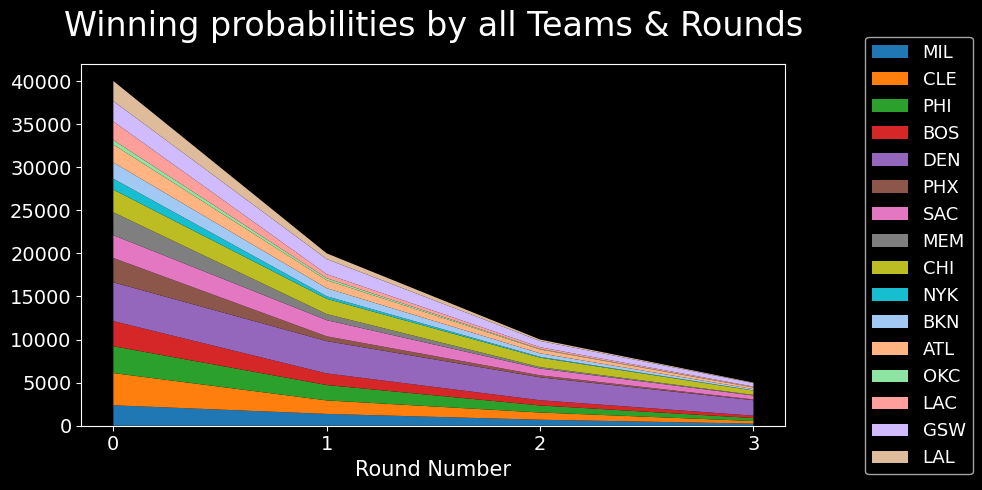

In [ ]:
# check that a team's wins should get less and less in later rounds
fig = plotting(playoff.rounds)

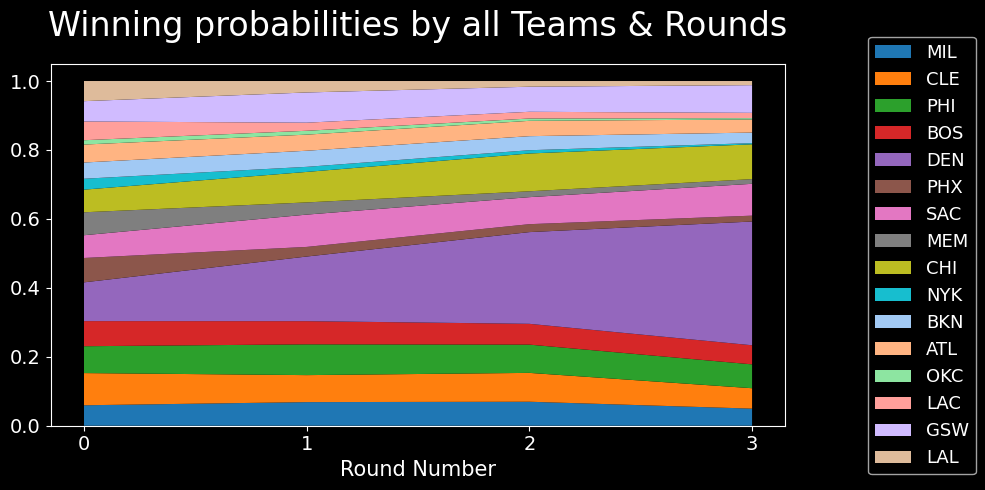

In [ ]:
# plot the results: probabilities of winning for all teams at each round
fig = plotting(playoff.rounds_probs)

### ☝️ Observations

1. Based on overall winning probabilities, the top 3 teams are: **Bucks > Lakers > Nuggets**.

2. Based on winning probabilities in the final round, the top 3 teams are: **Bucks > Lakers > Heat**.

3. **Bucks** has a much higher overall chance of winning, if it can get through the early rounds.

4. If we were the **Lakers**, we would avoid the **Bucks**; if we were the **Heat** or **Nuggets**, we would avoid both the **Bucks** and **Lakers**.

### 🌗 Results Comparison (actual 2019-2020 NBA playoff results)

In the actual 2019-2020 playoff, **Bucks** had lost to **Toronto Raptors** narrowly (3-4) at the 1st round. Lakers had, as we predicted, beat both **Nuggets** and **Heat** in the last two rounds and became the champion. These are mostly consistent with our model's predictions given the above observations. And since our model have not seen the 2019-2020 playoff data, it didn't "cheat" to get the results.

### 🤔 Debug: Why Raptors was able to beat Bucks?

From our observations, though Bucks' chances of winning in the early rounds are less than in later rounds,it still is much better than Raptors, how did Bucks lose? One hypothesis is that a strong team(e.g., Bucks), when facing particular type of opponent(e.g., Raptors), may become weaker. To comfirm this hypothesis, we can check the performance of Bucks when up against Raptors in our data.

In [ ]:
# extract games played by Bucks and Raptors

df_br_1 = df.loc[(df['HOME_TEAM_ID'] == 'Bucks') & (df['VISITOR_TEAM_ID'] == 'Raptors')].reset_index(drop=True)
df_br_2 = df.loc[(df['HOME_TEAM_ID'] == 'Raptors') & (df['VISITOR_TEAM_ID'] == 'Bucks')].reset_index(drop=True)


In [ ]:
print('Bucks won {} out of {} when being the home team'.format(
    sum(df_br_1['HOME_TEAM_WINS']), df_br_1.shape[0]))
print('Bucks won {} out of {} when being the away team'.format(
    df_br_2.shape[0] - sum(df_br_2['HOME_TEAM_WINS']), df_br_2.shape[0]))

Bucks won 18 out of 35 when being the home team
Bucks won 16 out of 36 when being the away team


In [ ]:
# bucks against Rapters
print("Bucks' chance of winning against Raptors: ", (18 + 16) /(35 + 36))

Bucks' chance of winning against Raptors:  0.4788732394366197


☝️The above explains why Bucks lost: It has little less than random chance of winning against Raptors. In sum, when we train the win/loss classifier, we should take into account which teams are competing as well!

## 🙂 Improvements

1. **Use more and better features**: Powerful simulations usually have more variables to cover more scenarios of the playoff. Using player level statistics is one way to go.

2. **Use better win/loss model**: Our trained SVM Discriminator only has about 70%+ accuracy, it is sufficient but nowhere near perfect. Improvements can be achieved by adding more data features or using a more powerful model such as Neural Network or ensemble model.

3. **Do better at distribution fitting**: In the projects, we used only a handful of distributions to speed up the fitting. To reduce the fitting errors, we can use more complex distributions. The lower the fitting error, the more realistic the samples we can generate.

4. **Run more simulations**: Should we have more variables to account for in our win/loss Discriminator, we need to run more simulations to get the precise probabilities.